## Colab Setting

In [ ]:
# Rendering problems in Colab 
# https://stackoverflow.com/questions/63250935/nameerror-name-base-is-not-defined-while-running-open-ai-gym-in-google-colab
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

!pip3 install box2d-py
!pip3 install gym[Box_2D]

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
#=========================================================#

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# why unwrapped
# https://stackoverflow.com/questions/53836136/why-unwrap-an-openai-gym
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,232 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

## Policy Gradient

In [ ]:
from torch import distributions

class PolicyEstimator(nn.Module):
  def __init__(self, observation_dim, action_dim):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(observation_dim, 16),
        nn.ReLU(),
        nn.Linear(16, action_dim),
        nn.Softmax(dim=-1)
    )
  
  def predict_actions_distribution(self, state):
    state = torch.FloatTensor(state)
    actions_prob = self.net(state)  
    actions_distribution = distributions.Categorical(actions_prob)
    return actions_distribution

In [ ]:
class State_Value_Estimator(nn.Module):
  def __init__(self, observation_dim, learning_rate=1e-3):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(observation_dim, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
    )
    self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
    self.loss_function = F.mse_loss
  
  def update(self, states, state_values):
    targets = torch.FloatTensor(state_values)
    predictions = self.net(states).squeeze()
    loss = self.loss_function(predictions, targets)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

In [ ]:
def discount_rewards_to_go(rewards, gamma=1):
  # Process discount factor gamma first
  r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
  # Reverse the array direction for cumsum and then
  # revert back to the original order
  r = r[::-1].cumsum()[::-1]
  # Normalization
  #r = r - r.mean()  # For CartPole specific, don't divide std seems more stable when converged
  #r = (r - r.mean()) / r.std()   # but if divide, seems like learn faster
  return r

## Training

In [ ]:
from collections import deque
from datetime import datetime

def train(env, policy_estimator, baseline=None, batch_size=8, num_episodes=1200, max_episode_length=400, learning_rate=1e-3, gamma=0.99):
  scores = []
  scores_window = deque(maxlen=100)
  time_step = 0
  start_time = datetime.now().replace(microsecond=0)

  batch_states = []
  batch_actions = []
  batch_rewards = []
  batch_counter = 0

  optimizer = optim.Adam(policy_estimator.net.parameters(), lr=learning_rate)

  for i_episode in range(1, num_episodes + 1):
    state = env.reset()
    score = 0
    
    # Why collect the whole trajectory transitions:
    # for vanilla policy gradient, we take rewards-to-go/Monte Carlo rewards(G) as advantages
    # which means we need the whole trajectory for one episode to calculate it
    # for other advanced methods, the advantages are more complex, and they
    # generally don't need the whole trajectory but record the "done" mark
    # for example, use TD error for DQN and DDPG
    sample_states = []
    sample_actions = []
    sample_rewards = []

    for t in range(1, max_episode_length + 1):
      actions_distribution = policy_estimator.predict_actions_distribution(state)
      action = actions_distribution.sample().item()

      next_state, reward, done, _ = env.step(action)

      sample_states.append(state)
      sample_actions.append(action)
      sample_rewards.append(reward)
      state = next_state

      score += reward
      time_step += 1

      if done:
        break

    scores_window.append(score)
    scores.append(score)

    batch_counter += 1
    batch_states.extend(sample_states)
    batch_actions.extend(sample_actions)
    
    # Preprocess the raw rewards first for better performance
    preprocessed_rewards = discount_rewards_to_go(sample_rewards, gamma)
    batch_rewards.extend(preprocessed_rewards)

    if batch_counter == batch_size:

      states_tensor = torch.FloatTensor(batch_states)
      actions_tensor = torch.Tensor(batch_actions)
      rewards_tensor = torch.FloatTensor(batch_rewards)

      # Calculate the loss
      if baseline:
        baseline_values = baseline.net(states_tensor)
        advantages = rewards_tensor - baseline_values

      else:
        advantages = rewards_tensor
      
      advantages = advantages - advantages.mean()
      #advantages = (advantages - advantages.mean()) / advantages.std()

      batch_actions_distributions = policy_estimator.predict_actions_distribution(states_tensor)
      log_probs = batch_actions_distributions.log_prob(actions_tensor)
      loss = - torch.sum(log_probs * advantages) / batch_size

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if baseline:
        baseline.update(states_tensor, rewards_tensor)

      batch_actions = []
      batch_states = []
      batch_rewards = []
      batch_counter = 0
      
    print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end='')
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
  end_time = datetime.now().replace(microsecond=0)
  print("Total training time  : ", end_time - start_time)
    
  return scores

### Without Baseline

Episode 100	Average Score: 27.15
Episode 200	Average Score: 35.98
Episode 300	Average Score: 54.55
Episode 400	Average Score: 63.46
Episode 500	Average Score: 96.23
Episode 600	Average Score: 152.25
Episode 700	Average Score: 195.64
Episode 800	Average Score: 195.31
Episode 900	Average Score: 198.26
Episode 1000	Average Score: 200.00
Episode 1100	Average Score: 199.50
Episode 1200	Average Score: 193.91
Total training time  :  0:00:47


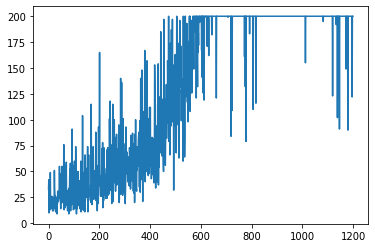

In [ ]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_estimator = PolicyEstimator(state_dim, action_dim)
PG_rewards = train(env, policy_estimator, batch_size=8, num_episodes=1200, learning_rate=1e-2, gamma=1)
plt.plot(PG_rewards)

### With state value as baseline

Episode 100	Average Score: 25.83
Episode 200	Average Score: 34.48
Episode 300	Average Score: 61.02
Episode 400	Average Score: 118.88
Episode 500	Average Score: 188.94
Episode 600	Average Score: 189.41
Episode 700	Average Score: 195.94
Episode 800	Average Score: 191.99
Episode 900	Average Score: 199.83
Episode 1000	Average Score: 198.36
Episode 1100	Average Score: 188.91
Episode 1200	Average Score: 195.84
Total training time  :  0:00:53


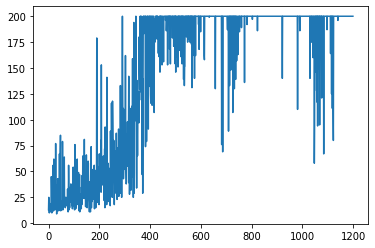

In [ ]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_estimator = PolicyEstimator(state_dim, action_dim)
baseline = State_Value_Estimator(4, learning_rate=1e-2)
PG_rewards = train(env, policy_estimator, baseline, batch_size=8, num_episodes=1200, learning_rate=1e-2, gamma=1)
plt.plot(PG_rewards)

## Conclusion

Generally, policy gradient with baseline should perform better. Without baseline, sometime the learning curve will oscillate, and not stable as the one with baseline. Also, without baseline, the learning speed (number of episodes to converge) will be slower.